# This code expolres some basic image properties of the dataset from the Data Science Bowl 2018
1. frequency distribution of number of masks of training data
2. image properties, dimensions and image sizes

In [2]:
# load necessary libraries, classes
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image


class ImagePreprocess:
    def __init__(self, all_matrix, datatype='images'):
        self.all_matrix = all_matrix
        
        if datatype == 'images':            
            self.image_norm = self.zero_mean()

        elif datatype == 'masks':
            masks = np.zeros((all_matrix.shape[1], all_matrix.shape[2]))
            for i in range(all_matrix.shape[0]):
                im = all_matrix[i, :, :]
                im = self.scale(im)
                im = self.find_contour(im)
                unique, unique_counts = np.unique(im,  return_counts=True)
                if len(unique) == 1 or np.isinf(im[:]).any():
                    # skip all black images and image with inf values
                    print('skip mask image with invalid values:',str(i))
                else:
                    masks = np.maximum(masks, im)
                
            self.mask_matrix = masks
            
        else: 
            print('datatype= images or masks.')    

    def zero_mean(self):    
    # image data pre-processing, normalize pixel values to zero-mean
    # data is a numpy array of shape (i, n, m), i is number of images, n and m are 2D image dimensions
        mean_all = np.mean(self.all_matrix, axis = 0)
        norm_all = np.empty(self.all_matrix.shape)
        for im in range(self.all_matrix.shape[0]):
            norm_one = self.all_matrix[im,:,:] - mean_all
            norm_all[im,:,:] = norm_one
            
        return norm_all


    def scale(self, im_array):
        # scale image pixel value to [0, 1.]
        im_array = np.divide(im_array, np.max(im_array))
        
        return im_array


    def find_contour(self, im_array):

        im = self.pad(im_array)
        im1 = np.multiply(im[0:-2, 0:-2], im[2:, 2:])
        im2 = np.multiply(im[0:-2, 2:], im[2:, 0:-2])
        im = np.multiply(im1, im2)
        #label pixels by 0=outer, 1=inner, 2=contour
        contour = im_array - im
        im[contour!=0] = 2

        return im

    

class LoadImage:
    # load files of one image at a time given the pathname
    def __init__(self, pathname, image_type='test'):
        self.pathname = pathname
        self.image_type = image_type        
        self.dict_path_file()


    def find_subfolder(self, pathname):
        subfolders = [d for d in os.listdir(pathname) if os.path.isdir(os.path.join(pathname,d))]

        return subfolders        

        
    def find_file(self, pathname):
        files = [d for d in os.listdir(pathname) if os.path.isfile(os.path.join(pathname,d))]
        return files


    def dict_path_file(self):
        # find image folder
        im_list = self.find_subfolder(self.pathname)
        # find the subfolders under each image folder
        dict_files = {}
        for n in range(len(im_list)):
            d = {'masks':[]}
            im_name = im_list[n]
            n_mask = None
            if self.image_type == 'train':
                # training data contains two folders under each item ../images, ../           
                list_mask = self.find_file(os.path.join(self.pathname, im_list[n] + '/masks/'))
                n_mask = len(list_mask)
                d['masks'] = list_mask
            
            dict_files[im_name] = d   
        self.dict_files = dict_files
        
    def load_image(self,filepath):
        im = Image.open(filepath).convert('L')
        im_array = np.asarray(im)
        
        return im_array
    
    def pile_image_matrix(self):
        # load all training images by filepath    
        # preprocess: resize images and normalize pixel values
        # relabel mask matrix
        # overlap mask matrix
        list_train = np.array(list(self.dict_files.keys()))
        n_img = len(list_train)
        shape = [256, 256]
        img_matrix = np.empty((n_img, shape[0], shape[1]))  
        mask_matrix = np.empty((n_img, shape[0], shape[1]))
        for i, it in enumerate(list_train):
            t_start = time.time()
            imgpath = self.pathname + '/' + it + '/images/' + it + '.png'
            m = self.load_image(imgpath)
            m = cv2.resize(m, (shape[0], shape[1]))
            img_matrix[i, :, :] = m
            if self.image_type == 'train':
                maskpath = [self.pathname + '/' + it + '/masks/' + m for m in self.dict_files[it]['masks']]
                mask = np.empty((len(maskpath), shape[0], shape[1]))
                for imp, mp in enumerate(maskpath):
                    m = self.load_image(mp)
                    m = cv2.resize(m, (shape[0], shape[1]))
                    mask[imp, :, :] = m
                I_mask = ImagePreprocess(mask, datatype='masks')
                mask_matrix[i, :, :] = I_mask.mask_matrix

            t_spent = time.time() - t_start
            print('image', str(i), ',time=', str(t_spent),'s')
        I_image = ImagePreprocess(img_matrix, datatype='images')
        image_matrix = I_image.image_norm

        return image_matrix, mask_matrix

First let's take a look at individual images and their corresponding masks:

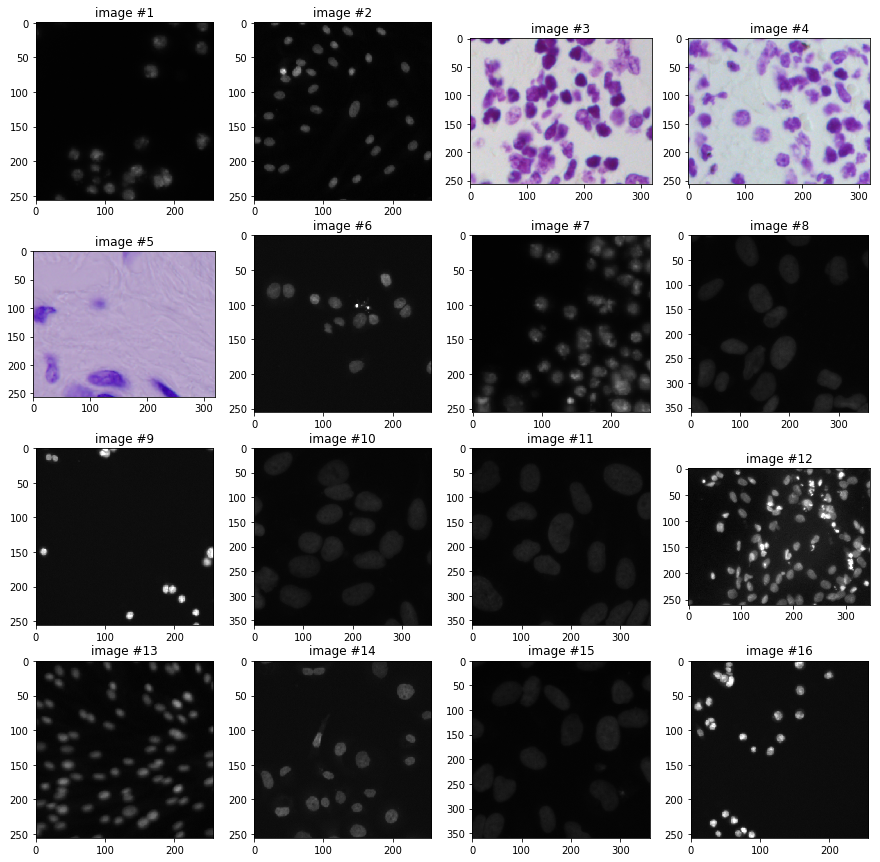

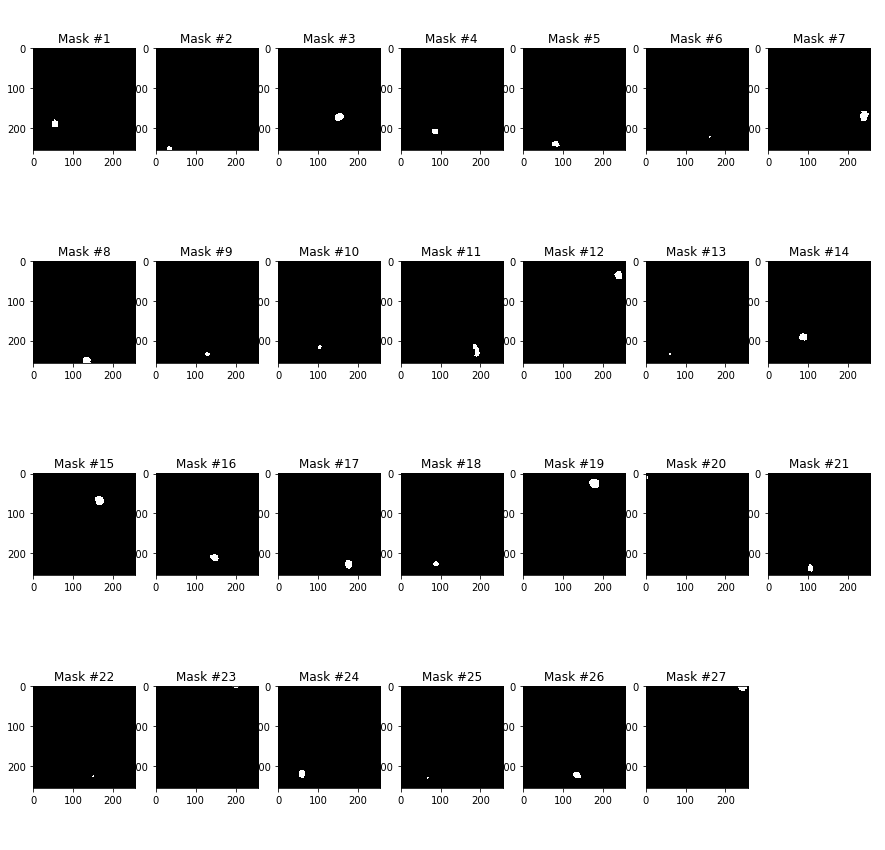

In [3]:
pathname = 'data/stage1_train'
im = LoadImage(pathname, image_type='train')
list_images = np.array(list(im.dict_files.keys()))
n_img = 15
plt.rcParams['figure.figsize'] = [15, 15]
fig, axes = plt.subplots(4,4)
# display images 
for n, ax in enumerate(axes.ravel()):
    path = pathname + '/' + list_images[n] + '/images/' + list_images[n] + '.png'
    im_array = Image.open(path)
    ax.imshow(im_array)
    ax.set_title('image #' + str(n+1))

# display masks of image # 1
maskpath = im.dict_files[list_images[0]]['masks']
n_mask = len(maskpath)
fig_mask, axes = plt.subplots()
plt.axis('off')
for nm in range(n_mask):
    ax_m = fig_mask.add_subplot(4,7,nm+1)
    path = pathname + '/' + list_images[0] + '/masks/' + maskpath[nm]
    mask_array = im.load_image(path)
    ax_m.imshow(mask_array, cmap='gray')
    ax_m.set_title('Mask #'+str(nm+1))
plt.show()

From the above results, we can see that the images are of different shapes and colors. For one given image, each mask dipicts a single nucleus in an image of the same size as the original image.
To take a closer look of the masks, let's plot the histogram of mask numbers across the whole training dataset. The majority of mask counts falls around 30.


Training Images: n= 670


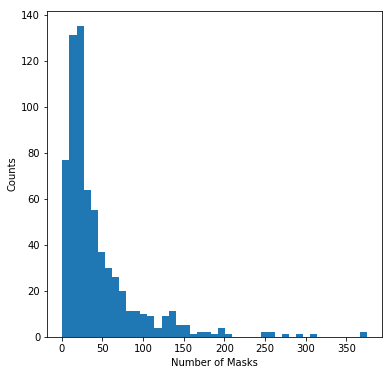

In [4]:

print('Training Images: n=', list_images.shape[0])
# histogram of count of training masks
n_masks = np.array([len(im.dict_files[list_images[n]]['masks']) for n in range(len(list_images))])
plt.rcParams['figure.figsize'] = [6, 6]
plt.hist(n_masks, bins='auto')
plt.ylabel('Counts')
plt.xlabel('Number of Masks')
plt.show()

Now we explore the distribution of image sizes, which would be later useful when we apply the convolutional neural networks that take inputs with the same size. 

In [5]:
# explore image sizes
sizes = []
for n in range(len(list_images)):
    path = pathname + '/' + list_images[n] + '/images/' + list_images[n] + '.png'
    im_array = im.load_image(path)
    sizes.append(im_array.shape)
    if n == 10:
        im0 = im_array
sizes = np.array(sizes)
unique, unique_counts = np.unique(sizes,  return_counts=True, axis=0)
print('Image sizes distribution:')
for n in range(len(unique)):
    print(unique[n],':', unique_counts[n])


1.17.4
Image sizes distribution:
[256 256] : 334
[256 320] : 112
[260 347] : 5
[360 360] : 91
[512 640] : 13
[520 696] : 92
[ 603 1272] : 6
[1024 1024] : 16
[1040 1388] : 1


The majority of image sizes are 256*256. For images with larger sizes, we will resize it to 256*256 to make the dataset homogeneous.